# Predicting if a user will make a purchase or not

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data retrieval

We begin by retrieving our purchase dataset which is found in a csv file

In [5]:
df = pd.read_csv('./Social_Network_Ads.csv')
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


## Data Preprocessing and Cleaning

It doesn't really matter what User ID the data belongs to, so we delete it as it as no effect on our model

In [8]:
df.drop('User ID', axis='columns', inplace=True)
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


We could have as well set 'v.id' as our index i.e. 
```python 
df.set_index('User ID', inplace=True)
```

Gender is categorical data, so we need to convert it to numerical. 

In [11]:
# from sklearn.preprocessing import LabelEncoder
# le_gender = LabelEncoder()
# df['Gender'] = le_gender.fit_transform(df['Gender'])

Also, since gender is ordinal without any inherent order, we use OneHotEncoder which treats each category independently.

In [13]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the Gender column
encoded_gender = one_hot_encoder.fit_transform(df[['Gender']])

# Convert the encoded_gender matrix to integers
encoded_gender = encoded_gender.astype(int)

# Create a DataFrame from the encoded gender data
encoded_gender_df = pd.DataFrame(encoded_gender, columns=one_hot_encoder.categories_[0], index=df.index)

# Concatenate the encoded Gender DataFrame with the original DataFrame.
df = pd.concat([df, encoded_gender_df], axis=1)

# Remove gender field since not needed again
df = df.drop('Gender', axis='columns')

# Let's reposition our dataset
df = df[['Age', 'EstimatedSalary', 'Male', 'Female', 'Purchased']]

In [14]:
df.head()

,Age,EstimatedSalary,Male,Female,Purchased
0,19,19000,1,0,0
1,35,20000,1,0,0
2,26,43000,0,1,0
3,27,57000,0,1,0
4,19,76000,1,0,0


## Exploratory Data Analysis (EDA)

We need to explore our dataset more by going through an EDA

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Male             400 non-null    int64
 3   Female           400 non-null    int64
 4   Purchased        400 non-null    int64
dtypes: int64(5)
memory usage: 15.8 KB


In [18]:
df.describe() # Generate descriptive statistics of our dataset

,Age,EstimatedSalary,Male,Female,Purchased
count,400.000000,400.000000,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.490000,0.510000,0.357500
std,10.482877,34096.960282,0.500526,0.500526,0.479864
min,18.000000,15000.000000,0.000000,0.000000,0.000000
25%,29.750000,43000.000000,0.000000,0.000000,0.000000
50%,37.000000,70000.000000,0.000000,1.000000,0.000000
75%,46.000000,88000.000000,1.000000,1.000000,1.000000
max,60.000000,150000.000000,1.000000,1.000000,1.000000


In [19]:
df[df.duplicated()] # Check for duplicates

,Age,EstimatedSalary,Male,Female,Purchased
74,32,18000,1,0,0
94,29,83000,0,1,0
186,20,82000,0,1,0
192,29,43000,1,0,0
231,39,42000,1,0,0
236,40,57000,1,0,0
256,41,72000,0,1,0
257,40,57000,1,0,0
312,38,50000,0,1,0
322,41,52000,1,0,0


After dropping the 'User ID' we realize that duplicated data now exists given that multiple users may have same outcome. This is noise in our data. So we still perform cleaning again.

In [21]:
df = df.drop_duplicates()

Let's visualize how each feature plots against our Purchased

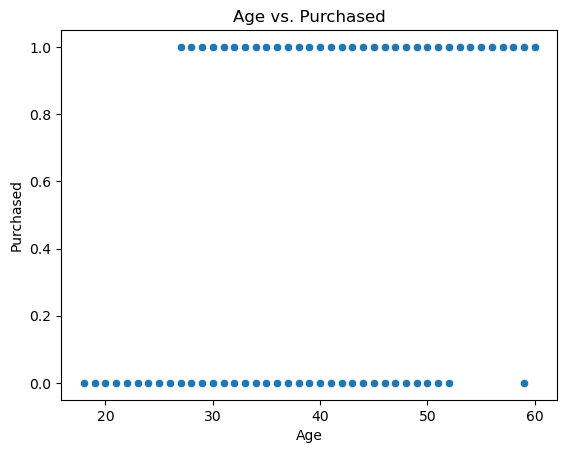

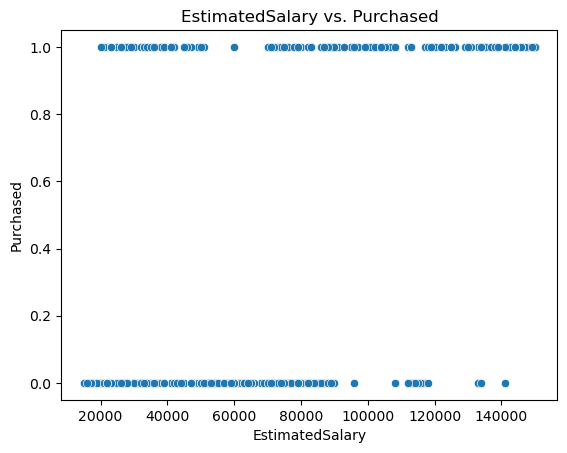

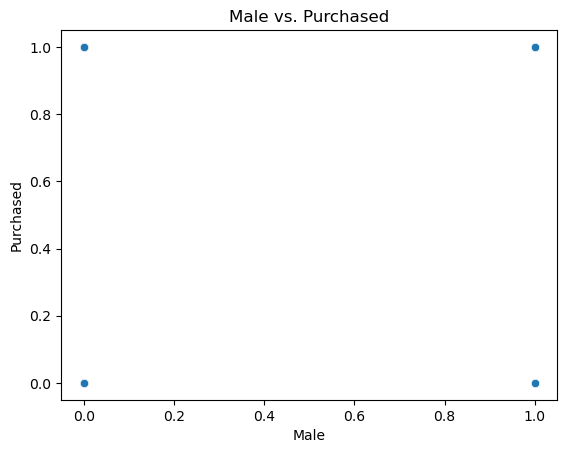

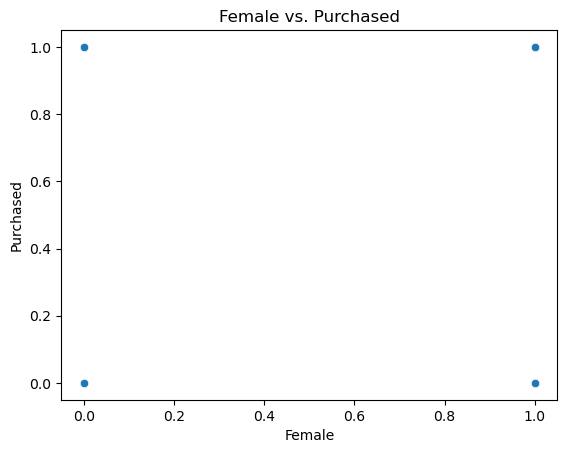

In [23]:
for feature in df.columns[:-1]:
    sns.scatterplot(x=df[feature], y=df['Purchased'])
    plt.title(f'{feature} vs. Purchased')
    plt.xlabel(feature)
    plt.ylabel('Purchased')
    plt.show()

Let's try to see how correlated the features are with the dependent variable

In [25]:
corr_matrix = df.corr()
corr_matrix

,Age,EstimatedSalary,Male,Female,Purchased
Age,1.000000,0.170588,-0.093522,0.093522,0.626505
EstimatedSalary,0.170588,1.000000,-0.039119,0.039119,0.374928
Male,-0.093522,-0.039119,1.000000,-1.000000,-0.044257
Female,0.093522,0.039119,-1.000000,1.000000,0.044257
Purchased,0.626505,0.374928,-0.044257,0.044257,1.000000


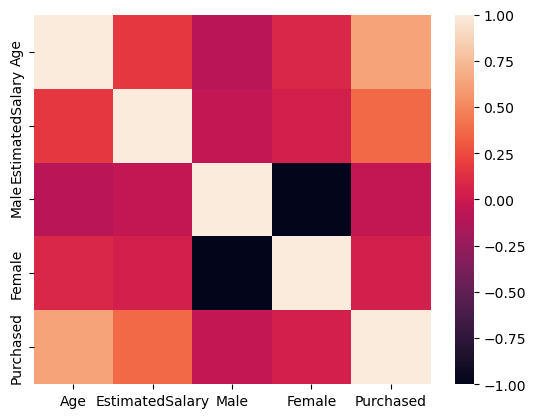

In [26]:
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.show()
plt.close()

We atleast have some correlation among the independent as well as the dependent variables. 
Only Gender is poorly correlated. But we still proceed with all features.

## Modeling

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report

We begin by separating our dataset into dependent and independent variables, y and X respectively.

In [31]:
y = df['Purchased']
y[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    0
9    0
Name: Purchased, dtype: int64

In [32]:
X = df.drop('Purchased', axis='columns')
X.head()

,Age,EstimatedSalary,Male,Female
0,19,19000,1,0
1,35,20000,1,0
2,26,43000,0,1
3,27,57000,0,1
4,19,76000,1,0


We split our dataset into training and test datasets

In [34]:
# Train 75% and Test 25% of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [35]:
model = LogisticRegression() 

In [36]:
model.fit(X_train, y_train) # Train our model

LogisticRegression()

In [37]:
y_predicted = model.predict(X_test) # Predict our test data
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Model evaluation and Validation

In [39]:
model_score = model.score(X_test, y_test) # Score our model
model_score

0.6973684210526315

Let's visualize the confusion matrix

In [41]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[53,  0],
       [23,  0]])

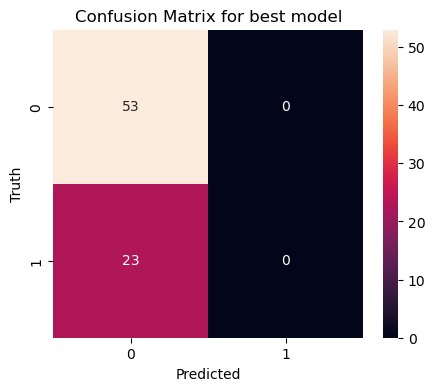

In [42]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for best model')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [43]:
kf = KFold(shuffle=True, n_splits=5) # We want to apply shuffling, so we use K-Fold.

In [44]:
# Accuracy score
scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy') 
scores

array([0.65789474, 0.68421053, 0.63157895, 0.80263158, 0.59210526])

In [45]:
scores.mean()

0.6736842105263158

In [46]:
# Let's visualize other scoring with classification report
print(classification_report(y_test, y_predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82        53
           1       0.00      0.00      0.00        23

    accuracy                           0.70        76
   macro avg       0.35      0.50      0.41        76
weighted avg       0.49      0.70      0.57        76



## Model optimization and improvements

* Our model's score is somewhat average, sometimes good.
* But, frankly speaking our model is terrible at predicting True positive values which makes us to think a lot is going on wrong.
* One thing we can do is try to fine-tune our hyperparameters for our model.

### Hyperparameter Tunning

In [50]:
from sklearn.model_selection import GridSearchCV

The values gotten above for our param_grid is obviously true try-and-error i.e. trying things out to see which makes sense. 
A little information about what each parameter will go a long way and which params combination works together. 

In [52]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization to apply
    'solver': ['liblinear'],  # Algorithm to use for optimization
    'max_iter': [100, 150, 200, 250],  # Max iterations to converge
}

In [53]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [54]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/molinge/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 150, 200, 250],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

In [55]:
# Get best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.84


In [56]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_score))

Test set accuracy: 0.84


In [57]:
best_y_predicted = best_model.predict(X_test) # Predict our test data
best_y_predicted

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0])

In [58]:
best_cm = confusion_matrix(y_test, best_y_predicted)
best_cm

array([[46,  7],
       [ 5, 18]])

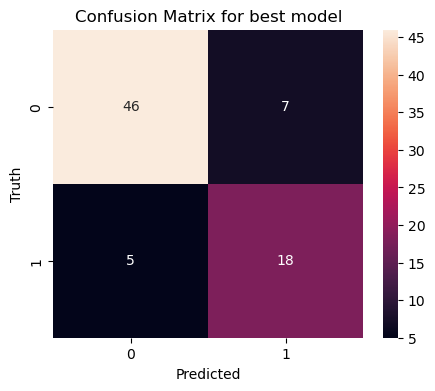

In [59]:
plt.figure(figsize=(5,4))
sns.heatmap(best_cm, annot=True)
plt.title('Confusion Matrix for best model')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Results

We started by using the simplest form of LogisticRegression which actually peforms poorly with a 69.7% accuracy on our dataset. 
We later fine-tuned the model's hyperparameter to get a score of 84%.

If we look above under hyperparameter tunning, we can see a confusion matrix which shows how well our model performs.